In [44]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

In [45]:
# Load Dataset: 
data_file = "../usaa_swim_data/swimmers_cleaned.csv"
# Filter data for this event
df_cleaned = pd.read_csv(data_file)

print(df_cleaned.head())

         Name      Event   Time  Age_at_time_of_Swim  \
0  Alex Walsh  50 FR SCY  22.08                   16   
1  Alex Walsh  50 FR SCY  22.18                   18   
2  Alex Walsh  50 FR SCY  22.24                   17   
3  Alex Walsh  50 FR SCY  22.28                   16   
4  Alex Walsh  50 FR SCY  22.35                   16   

                      Time_cut  Time_cut_points   Swim_date Specialty_1  \
0  2018 Summer Nationals (LCM)               19  2018-03-03      200 IM   
1  2021 Summer Nationals (LCM)               19  2020-03-06      200 IM   
2  2019 Summer Nationals (LCM)               19  2019-03-02      200 IM   
3  2018 Summer Nationals (LCM)               19  2017-12-07      200 IM   
4  2018 Winter Nationals (LCM)               18  2017-12-07      200 IM   

  Specialty_2 Stroke_1 Stroke_2 Stroke_3  
0  200 Breast       IM   Breast     Back  
1  200 Breast       IM   Breast     Back  
2  200 Breast       IM   Breast     Back  
3  200 Breast       IM   Breast     Back

In [46]:
# Since the specialty is just "200 IM" for instance, and event would be "200 IM SCY", 
# we need to account for this to make the specialty match up with the event name

# Focus on SCY events
df_cleaned = df_cleaned[df_cleaned['Event'].str.contains("SCY")]

# Define stroke mapping for consistency
stroke_mapping = {
    "Free": "FR",
    "Back": "BK",
    "Breast": "BR",
    "Fly": "FL",
    "IM": "IM"
}
# Remove course type (SCY, LCM, SCM) from ALL Event names in df_cleaned
df_cleaned["Event"] = df_cleaned["Event"].str.replace(" SCY", "", regex=False)
df_cleaned["Event"] = df_cleaned["Event"].str.replace(" LCM", "", regex=False)
df_cleaned["Event"] = df_cleaned["Event"].str.replace(" SCM", "", regex=False)


# Convert `Specialty_1` and `Specialty_2` to match event format
df_cleaned["Specialty_1"] = df_cleaned["Specialty_1"].replace(stroke_mapping, regex=True)
df_cleaned["Specialty_2"] = df_cleaned["Specialty_2"].replace(stroke_mapping, regex=True)

# Print to verify conversion
print("Updated Specialty_1 Values:", df_cleaned["Specialty_1"].unique()[:20])
print("Updated Specialty_2 Values:", df_cleaned["Specialty_2"].unique()[:20])



Updated Specialty_1 Values: ['200 IM' '400 IM' '200 FR' nan '100 BK' '100 FL' '200 FL' '50 FR'
 '100 BR' '200 BR' '200 BK' '1650 FR' '1000 FR']
Updated Specialty_2 Values: ['200 BR' '500 FR' '200 FL' '400 FR' '400 IM' nan '200 IM' '100 FR'
 '200 BK' '100 FL' '201 FL' '100 BR' '100 BK' '50 FR' '1000 FR' '1650 FR'
 '800 FR']


In [47]:
# Select a specific event to analyze
raw_event_name = "100 Free SCY"  # Example

# Get unique events
unique_events = df_cleaned["Event"].unique()

# Store results
results = {}

In [48]:
# Remove course type (SCY, LCM, SCM)
event_minus_course_name = raw_event_name.replace(" SCY", "").replace(" LCM", "").replace(" SCM", "")
event_parts = event_minus_course_name.split()

# Extract event distance and stroke
event_distance = event_parts[0]  # Example: "50"
event_stroke = event_parts[1]  # Example: "Free"

# Convert event name to correct format ("50 FR")
event_name = f"{event_distance} {stroke_mapping.get(event_stroke, event_stroke)}"

print("Formatted Event Name:", event_name)


Formatted Event Name: 100 FR


In [49]:
# Identify Specialists & Non-Specialists
specialist_data = df_cleaned[
    (df_cleaned["Event"] == event_name) &
    ((df_cleaned["Specialty_1"] == event_name) | (df_cleaned["Specialty_2"] == event_name))
    ]

non_specialist_data = df_cleaned[
    (df_cleaned["Event"] == event_name) &
    ~((df_cleaned["Specialty_1"] == event_name) | (df_cleaned["Specialty_2"] == event_name))
    ]


# Print counts to verify
print(f"Specialists Found: {specialist_data.shape[0]}")
print(f"Non-Specialists Found: {non_specialist_data.shape[0]}")

print("Unique Event Values in df_cleaned:", df_cleaned["Event"].unique()[:20])
print("Unique Specialty_1 Values in df_cleaned:", df_cleaned["Specialty_1"].unique()[:20])
print("Unique Specialty_2 Values in df_cleaned:", df_cleaned["Specialty_2"].unique()[:20])
print("Formatted Event Name:", event_name)


Specialists Found: 702
Non-Specialists Found: 4863
Unique Event Values in df_cleaned: ['50 FR' '100 FR' '200 FR' '500 FR' '50 BK' '100 BK' '200 BK' '50 BR'
 '100 BR' '200 BR' '50 FL' '100 FL' '200 FL' '100 IM' '200 IM' '400 IM'
 '1000 FR' '1650 FR']
Unique Specialty_1 Values in df_cleaned: ['200 IM' '400 IM' '200 FR' nan '100 BK' '100 FL' '200 FL' '50 FR'
 '100 BR' '200 BR' '200 BK' '1650 FR' '1000 FR']
Unique Specialty_2 Values in df_cleaned: ['200 BR' '500 FR' '200 FL' '400 FR' '400 IM' nan '200 IM' '100 FR'
 '200 BK' '100 FL' '201 FL' '100 BR' '100 BK' '50 FR' '1000 FR' '1650 FR'
 '800 FR']
Formatted Event Name: 100 FR


In [50]:
# Compute mean swim time per age for specialists
specialist_means = specialist_data.groupby("Age_at_time_of_Swim")["Time"].mean()

# Compute mean swim time per age for non-specialists
non_specialist_means = non_specialist_data.groupby("Age_at_time_of_Swim")["Time"].mean()

# Print the computed means
print("Specialists Mean Swim Times:\n", specialist_means)
print("\nNon-Specialists Mean Swim Times:\n", non_specialist_means)

Specialists Mean Swim Times:
 Age_at_time_of_Swim
5     107.700000
6      88.041667
7      78.538889
8      72.856667
9      67.657273
10     62.151316
11     58.390000
12     55.588983
13     53.434464
14     51.595667
15     51.101964
16     50.105455
17     49.975349
18     49.849189
19     49.493421
20     48.560426
21     48.493333
22     48.315517
23     47.307500
24     49.120000
Name: Time, dtype: float64

Non-Specialists Mean Swim Times:
 Age_at_time_of_Swim
5     110.950000
6      98.932353
7      90.483168
8      80.718737
9      73.119301
10     67.629884
11     61.837043
12     57.681318
13     55.493655
14     53.751120
15     52.622092
16     51.917731
17     51.654827
18     51.132222
19     50.360340
20     50.046250
21     49.459690
22     48.973429
23     48.496429
24     49.510000
28     49.980000
Name: Time, dtype: float64


In [51]:
# Ensure age is sorted for proper time series analysis
specialist_means = specialist_means.sort_index()
non_specialist_means = non_specialist_means.sort_index()

# Print to verify structure
print("Specialist Mean Swim Times:\n", specialist_means)
print("\nNon-Specialist Mean Swim Times:\n", non_specialist_means)


Specialist Mean Swim Times:
 Age_at_time_of_Swim
5     107.700000
6      88.041667
7      78.538889
8      72.856667
9      67.657273
10     62.151316
11     58.390000
12     55.588983
13     53.434464
14     51.595667
15     51.101964
16     50.105455
17     49.975349
18     49.849189
19     49.493421
20     48.560426
21     48.493333
22     48.315517
23     47.307500
24     49.120000
Name: Time, dtype: float64

Non-Specialist Mean Swim Times:
 Age_at_time_of_Swim
5     110.950000
6      98.932353
7      90.483168
8      80.718737
9      73.119301
10     67.629884
11     61.837043
12     57.681318
13     55.493655
14     53.751120
15     52.622092
16     51.917731
17     51.654827
18     51.132222
19     50.360340
20     50.046250
21     49.459690
22     48.973429
23     48.496429
24     49.510000
28     49.980000
Name: Time, dtype: float64


In [52]:
# Check for stationarity Before Applying ARIMA 

# ARIMA assumes stationarity, meaning the time series should have a constant mean and variance. 

def check_stationarity(series, name="Time Series"):
    result = adfuller(series.dropna())  # Drop NaN values before ADF test
    print(f"\n{name} ADF Test Results:")
    print(f"Test Statistic: {result[0]}")
    print(f"P-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] <= 0.05:
        print(f"{name} is likely stationary (p ≤ 0.05). No differencing needed.")
    else:
        print(f"{name} is likely non-stationary (p > 0.05), consider differencing.")

# Check stationarity for both groups
check_stationarity(specialist_means, "Specialist Swim Times")
check_stationarity(non_specialist_means, "Non-Specialist Swim Times")


Specialist Swim Times ADF Test Results:
Test Statistic: -79.03181241933636
P-value: 0.0
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
Specialist Swim Times is likely stationary (p ≤ 0.05). No differencing needed.

Non-Specialist Swim Times ADF Test Results:
Test Statistic: -1.610897213566814
P-value: 0.47750464860067754
Critical Values: {'1%': -4.01203360058309, '5%': -3.1041838775510207, '10%': -2.6909873469387753}
Non-Specialist Swim Times is likely non-stationary (p > 0.05), consider differencing.


In [53]:


# Auto-select ARIMA order for specialists (d=0)
specialist_auto_arima = auto_arima(specialist_means, seasonal=False, d=0, stepwise=True, suppress_warnings=True)
print("Best ARIMA Order for Specialists:", specialist_auto_arima.order)

# Auto-select ARIMA order for non-specialists (d=1)
non_specialist_auto_arima = auto_arima(non_specialist_means.diff().dropna(), seasonal=False, d=1, stepwise=True, suppress_warnings=True)
print("Best ARIMA Order for Non-Specialists:", non_specialist_auto_arima.order)

Best ARIMA Order for Specialists: (4, 0, 0)
Best ARIMA Order for Non-Specialists: (1, 1, 0)


In [54]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Define ARIMA model order (p, d, q) - 
arima_order = (1, 1, 1)  # Can be tuned

# Fit ARIMA for specialists - Predicts how they improve with age.
specialist_arima_model = ARIMA(specialist_means, order=arima_order)
specialist_arima_fit = specialist_arima_model.fit()

# Fit ARIMA for non-specialists -  Predicts how they improve with age.
non_specialist_arima_model = ARIMA(non_specialist_means, order=arima_order)
non_specialist_arima_fit = non_specialist_arima_model.fit()

# Print summaries
print("Specialist ARIMA Model Summary:\n", specialist_arima_fit.summary())
print("\nNon-Specialist ARIMA Model Summary:\n", non_specialist_arima_fit.summary())


Specialist ARIMA Model Summary:
                                SARIMAX Results                                
Dep. Variable:                   Time   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -45.549
Date:                Thu, 13 Mar 2025   AIC                             97.097
Time:                        12:34:46   BIC                             99.930
Sample:                             0   HQIC                            97.577
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9612      0.067     14.443      0.000       0.831       1.092
ma.L1          0.5804      0.847      0.685      0.493      -1.080       2.240
sigma2         5.76

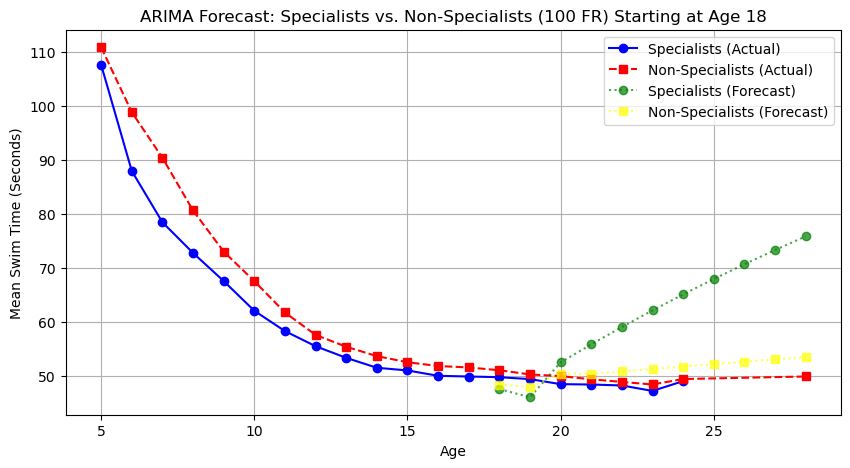

In [55]:
plt.figure(figsize=(10, 5))

# Plot actual means
plt.plot(specialist_means.index, specialist_means.values, marker='o', linestyle='-', label="Specialists (Actual)", color='blue')
plt.plot(non_specialist_means.index, non_specialist_means.values, marker='s', linestyle='--', label="Non-Specialists (Actual)", color='red')

# Define forecast horizon (e.g., predict from 18 onward)
forecast_start_age = 18
forecast_horizon = 10  # Predict for 10 years (18 to 28)

# Generate predictions starting at age 18
specialist_forecast = specialist_arima_fit.predict(start=forecast_start_age, end=forecast_start_age + forecast_horizon)
non_specialist_forecast = non_specialist_arima_fit.predict(start=forecast_start_age, end=forecast_start_age + forecast_horizon)

# Plot forecasts
plt.plot(range(forecast_start_age, forecast_start_age + forecast_horizon + 1), specialist_forecast, 
         marker='o', linestyle='dotted', label="Specialists (Forecast)", color='green', alpha=0.7)

plt.plot(range(forecast_start_age, forecast_start_age + forecast_horizon + 1), non_specialist_forecast, 
         marker='s', linestyle='dotted', label="Non-Specialists (Forecast)", color='yellow', alpha=0.7)

# Labels & legend
plt.xlabel("Age")
plt.ylabel("Mean Swim Time (Seconds)")
plt.title(f"ARIMA Forecast: Specialists vs. Non-Specialists ({event_name}) Starting at Age 18")
plt.legend()
plt.grid()

plt.show()